# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Sat May 28 18:07:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:10 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease [20.8 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/c2d4u.te

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

# cuDF and cuML Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

In [ ]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
6    15.622920
1    21.729202
4    14.594901
3    15.215685
2    16.571919
5    14.149549
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)#

This snippet loads a 

As above, all calculations are performed on the GPU.

In [ ]:
import cuml

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [ ]:
import cugraph

# Computing betweenness centrality with different packages #
1. install packages 1) osmnx, 2) igraph, 3) graph-tool
2. Reference:
https://github.com/gboeing/osmnx/issues/710
https://github.com/gboeing/osmnx-examples/blob/main/notebooks/14-osmnx-to-igraph.ipynb






In [ ]:
!pip install osmnx

In [ ]:
!pip install igraph

In [ ]:
!apt install libcairo2-dev
!pip install pycairo

In [ ]:
#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

# 0. Import packages #

In [ ]:
import osmnx as ox
import networkx as nx

import igraph as ig
import graph_tool.all as gt
import cugraph
import numpy as np

import operator
import time

%matplotlib inline
print(ox.__version__)
print(ig.__version__)
print(nx.__version__)

weight = "length"

1.1.2
0.9.10
2.7.1


# 1. Work with small network #

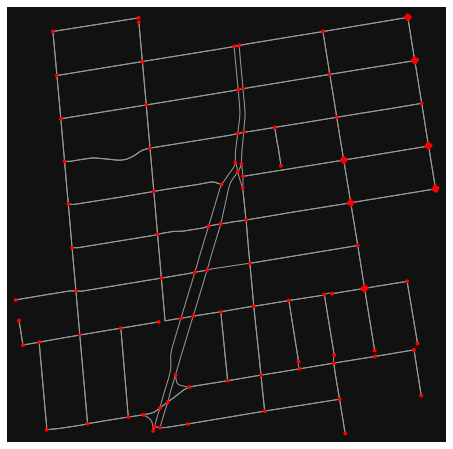

In [ ]:
# create networkx graph (small size) ############G_nx
point = 37.858495, -122.267468

G_nx = ox.graph_from_point(point, network_type="drive", dist=500)
fig, ax = ox.plot_graph(G_nx, node_color="r")
osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

In [ ]:
# convert networkx graph to igraph ############G_ig
%%time
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es[weight] = list(nx.get_edge_attributes(G_nx, weight).values())

CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.53 ms


In [ ]:
# convert networkx graph to graph-tool ############G_gt
%%time
G_gt = gt.Graph(directed=True)
v_prop = G_gt.new_vertex_property("double")
e_prop = G_gt.new_edge_property("double")

for i in range(0, len(G_nx.nodes)):
  v= G_gt.add_vertex()
  v_prop[v] = osmids[i]

for i in range(0,len(list(G_nx.edges()))):
  edge_temp = list(G_nx.edges())[i]
  e = G_gt.add_edge(edge_temp[0], edge_temp[1])
  e_prop[e] = list(nx.get_edge_attributes(G_nx, weight).values())[i]

G_gt.vertex_properties["osmid"] = v_prop
G_gt.edge_properties[weight] = e_prop

CPU times: user 148 ms, sys: 884 µs, total: 149 ms
Wall time: 151 ms


In [ ]:
# networkx 
%%time
bc_nx = nx.betweenness_centrality(ox.get_digraph(G_nx), weight="length")
print(bc_nx)

{0: 0.06550709588092767, 1: 0.031152647975077885, 2: 0.08359293873312565, 3: 0.20629975770162687, 4: 0.24731741086881276, 5: 0.018431983385254414, 6: 0.06602630668051229, 7: 0.11318795430944964, 8: 0.11431291104188301, 9: 0.1124956732433368, 10: 0.18535825545171342, 11: 0.15022499134648667, 12: 0.0, 13: 0.040065766701280724, 14: 0.03011422637590862, 15: 0.10271720318449291, 16: 0.12262028383523711, 17: 0.018431983385254414, 18: 0.03989269643475251, 19: 0.0844582900657667, 20: 0.10470751124956733, 21: 0.06429560401523018, 22: 0.20257874697127035, 23: 0.08541017653167186, 24: 0.06628591208030461, 25: 0.018431983385254414, 26: 0.018431983385254414, 27: 0.0, 28: 0.05694011768778124, 29: 0.04266182069920388, 30: 0.040758047767393564, 31: 0.08670820353063344, 32: 0.08757355486327449, 33: 0.01090342679127726, 34: 0.10211145725164418, 35: 0.08670820353063344, 36: 0.028210453444098307, 37: 0.15602284527518173, 38: 0.018431983385254414, 39: 0.041796469366562825, 40: 0.041796469366562825, 41: 0.1

In [ ]:
# igraph
%%time
bc_ig = G_ig.betweenness(vertices=None, cutoff=None, weights=weight)
print(bc_ig)

[757.0, 360.0, 966.0, 2384.0, 2858.0, 213.0, 763.0, 1308.0, 1321.0, 1300.0, 2142.0, 1736.0, 0.0, 463.0, 348.0, 1187.0, 1417.0, 213.0, 461.0, 976.0, 1210.0, 743.0, 2341.0, 987.0, 766.0, 213.0, 213.0, 0.0, 658.0, 493.0, 471.0, 1002.0, 1012.0, 126.0, 1180.0, 1002.0, 326.0, 1803.0, 213.0, 483.0, 483.0, 1561.0, 357.0, 422.0, 213.0, 481.0, 0.0, 819.0, 580.0, 1464.0, 742.0, 651.0, 904.0, 295.0, 717.0, 1269.0, 893.0, 1048.0, 1124.0, 1423.0, 1688.0, 1071.0, 1827.0, 0.0, 284.0, 0.0, 591.0, 0.0, 276.0, 0.0, 0.0, 0.0, 716.0, 285.0, 0.0, 0.0, 600.0, 1189.0, 708.0, 1640.0, 1690.0, 1781.0, 1300.0, 1823.0, 185.0, 739.0, 186.0, 596.0, 1613.0, 1131.0, 890.0, 1241.0, 638.0, 577.0, 230.0, 497.0, 502.0, 674.0, 221.0, 372.0, 277.0, 442.0, 128.0, 129.0, 121.0, 944.0, 1023.0, 1033.0, 84.0]
CPU times: user 5.29 ms, sys: 769 µs, total: 6.06 ms
Wall time: 16 ms


In [ ]:
# graph-tool
%%time
v_bc_gt, e_bc_gt = graph_tool.centrality.betweenness(G_gt, weight=e_prop)
print(v_bc_gt.a)

[0.0655071  0.03115265 0.08359294 0.20629976 0.24731741 0.01843198
 0.06602631 0.11318795 0.11431291 0.11249567 0.18535826 0.15022499
 0.         0.04006577 0.03011423 0.1027172  0.12262028 0.01843198
 0.0398927  0.08445829 0.10470751 0.0642956  0.20257875 0.08541018
 0.06628591 0.01843198 0.01843198 0.         0.05694012 0.04266182
 0.04075805 0.0867082  0.08757355 0.01090343 0.10211146 0.0867082
 0.02821045 0.15602285 0.01843198 0.04179647 0.04179647 0.13508134
 0.03089304 0.03651783 0.01843198 0.0416234  0.         0.07087227
 0.05019038 0.12668744 0.06420907 0.05633437 0.07822776 0.02552786
 0.06204569 0.10981308 0.07727587 0.09068882 0.09726549 0.12313949
 0.1460713  0.09267913 0.15809969 0.         0.02457598 0.
 0.05114226 0.         0.0238837  0.         0.         0.
 0.06195916 0.02466251 0.         0.         0.05192108 0.10289027
 0.06126687 0.14191762 0.14624438 0.15411907 0.11249567 0.15775355
 0.016009   0.06394946 0.01609553 0.05157494 0.13958117 0.09787124
 0.07701627 

In [ ]:
# cugraph
%%time
bc = cugraph.betweenness_centrality(ox.get_digraph(G_nx), weight="length")

NotImplementedError: ignored

# 1. Work with large network #

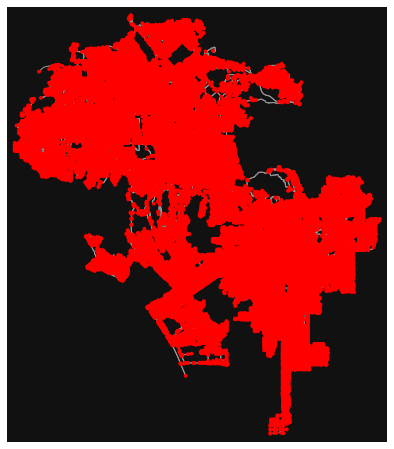

In [ ]:
# create networkx graph (large size) ############G_nx
G_nx = ox.graph_from_place("Los Angeles, CA, USA", network_type="drive")
fig, ax = ox.plot_graph(G_nx, node_color="r")
osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

In [ ]:
# convert networkx graph to igraph ############G_ig
%%time
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es[weight] = list(nx.get_edge_attributes(G_nx, weight).values())

CPU times: user 603 ms, sys: 5.83 ms, total: 609 ms
Wall time: 608 ms


In [ ]:
# convert networkx graph to graph-tool ############G_gt
%%time
G_gt = gt.Graph(directed=True)
v_prop = G_gt.new_vertex_property("double")
e_prop = G_gt.new_edge_property("double")

#for i in range(0, len(G_nx.nodes)):
#  v= G_gt.add_vertex()
#  v_prop[v] = osmids[i]

edge_list = [(i,j,k) for ((i,j),k) in zip(list(G_nx.edges()), list(nx.get_edge_attributes(G_nx, weight).values()))]

e = G_gt.add_edge_list(edge_list, eprops=[e_prop])

CPU times: user 1.55 s, sys: 3.56 ms, total: 1.55 s
Wall time: 1.61 s


In [ ]:
# networkx 
%%time
bc_nx = nx.betweenness_centrality(ox.get_digraph(G_nx), weight="length")
print(bc_nx)

{0: 0.0023997959328674167, 1: 0.004008043872024464, 2: 0.0024672982633079416, 3: 0.0024820614277598343, 4: 0.006315491569333395, 5: 0.008814797720269801, 6: 0.007883862904192634, 7: 0.0017310549830080214, 8: 0.0012228582228757008, 9: 0.000594512149030593, 10: 0.0013166928535230321, 11: 6.245276608825822e-05, 12: 0.00024195504841350226, 13: 7.874452482804626e-07, 14: 0.0065771827324712295, 15: 0.005014749193649101, 16: 0.0028331423758121204, 17: 0.0051733616433420225, 18: 0.00015422537179563353, 19: 0.006527070978749622, 20: 0.006351883257251455, 21: 0.000917216798778429, 22: 0.0016554262339932805, 23: 0.002584854989335443, 24: 0.0039828882329795, 25: 5.570990766151532e-05, 26: 0.013601316847720486, 27: 0.013552435425986697, 28: 0.008673066998701436, 29: 0.0039012122977708885, 30: 0.0198150079706093, 31: 0.0024144603593875534, 32: 0.014314917184973209, 33: 0.013548525649709726, 34: 0.012703462926090332, 35: 0.008931623949482692, 36: 0.0006403966082299533, 37: 0.017800967207281016, 38: 0

In [ ]:
# igraph
%%time
bc_ig = G_ig.betweenness(vertices=None, cutoff=None, weights=weight)
print(bc_ig)

[5857433.0, 9782852.0, 6022193.0, 6058227.0, 15414881.0, 21515199.0, 19242969.0, 4225167.0, 2984758.0, 1451088.0, 3213790.0, 152435.0, 590565.0, 1922.0, 16053618.0, 12240023.0, 6915147.0, 12627165.0, 376434.0, 15931305.0, 15503706.0, 2238747.0, 4040572.0, 6309126.0, 9721452.0, 135977.0, 33198157.0, 33078847.0, 21169262.0, 9522097.0, 48364563.0, 5893226.0, 34939916.0, 33069304.0, 31006671.0, 21800349.0, 1563083.0, 43448683.0, 19804355.0, 8271554.0, 28019532.0, 16987749.0, 7285127.0, 12792351.0, 12910476.0, 2216900.0, 21956804.0, 1134433.0, 3682542.0, 13757369.0, 12354390.0, 12711630.0, 40734055.0, 44781261.0, 6659901.0, 98510.0, 752643.0, 4414000.0, 404414.0, 6329438.0, 3024289.0, 4087520.0, 5595798.0, 2979348.0, 9349142.0, 13108863.0, 90654424.0, 8357179.0, 78250439.0, 525082.0, 11194968.0, 16005591.0, 250404.0, 1729718.0, 22245188.0, 13110703.0, 25644470.0, 1779756.0, 350632.0, 3394995.0, 3396998.0, 5769973.0, 8556726.0, 18151732.0, 2127690.0, 4125652.0, 1623173.0, 4121533.0, 29610505

In [ ]:
# graph-tool
%%time
v_bc_gt, e_bc_gt = graph_tool.centrality.betweenness(G_gt, weight=e_prop)
print(v_bc_gt.a)

[2.39979593e-03 4.00804387e-03 2.46729826e-03 ... 1.86663855e-05
 8.68566039e-07 0.00000000e+00]
CPU times: user 15min 19s, sys: 5.63 s, total: 15min 25s
Wall time: 7min 56s


In [ ]:
G2 = ox.get_digraph(G)

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1500: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from 'gi' (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
bc = graph_tool.centrality.betweenness(ox.get_digraph(G), vertices=None, directed=False)

TypeError: ignored

In [ ]:
bc = G2.betweenness(ox.get_digraph(G))

AttributeError: ignored

In [ ]:
g = ig.Graph.Famous("petersen")

In [ ]:
bc = ig.Graph.betweenness(ox.get_digraph(G))

TypeError: ignored

1.1.2
0.9.10
2.7.1


In [ ]:
# create networkx graph
G_nx = ox.graph_from_point(point, network_type="drive", dist=100)
osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

In [ ]:
%%time
# convert networkx graph to igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es[weight] = list(nx.get_edge_attributes(G_nx, weight).values())

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.62 ms


In [ ]:
G_gt = gt.Graph(directed=True)
v_prop = G_gt.new_vertex_property("int")
e_prop = G_gt.new_edge_property("double")

for i in range(0, len(G_nx.nodes)):
  v= G_gt.add_vertex()
  v_prop[v] = osmids[i]

for i in range(0,len(list(G_nx.edges()))):
  edge_temp = list(G_nx.edges())[i]
  e = G_gt.add_edge(edge_temp[0], edge_temp[1])
  e_prop[e] = list(nx.get_edge_attributes(G_nx, weight).values())[i]

In [ ]:
G_gt.vertex_properties["osmid"] = v_prop
G_gt.edge_properties[weight] = e_prop

In [ ]:
vc, ec = graph_tool.centrality.betweenness(G_gt, weight=e_prop)

In [ ]:
vc.a

PropertyArray([0.45, 0.6 , 0.  , 0.  , 0.  , 0.2 ])

In [ ]:
G_gt.edges().next()

AttributeError: ignored

In [ ]:
G_gt.edges[]

TypeError: ignored

In [ ]:
for i in G_nx.edges():
  print((i))

(0, 5)
(0, 1)
(1, 4)
(1, 2)
(1, 0)
(2, 1)
(3, 5)
(4, 1)
(5, 0)


In [ ]:
g = gt.Graph()
v = g.vertex(8)

ValueError: ignored

In [ ]:
osmids

[53037907, 53037909, 53064680, 275778689, 275779238, 275782472]

In [ ]:
assert len(G_nx.nodes()) == G_ig.vcount()
assert len(G_nx.edges()) == G_ig.ecount()

In [ ]:
%%time
closeness1 = G_ig.closeness(vertices=None, mode="ALL", cutoff=None, weights=weight, normalized=True)
max_closeness1 = np.argmax(closeness1)

CPU times: user 24.7 ms, sys: 0 ns, total: 24.7 ms
Wall time: 88.5 ms


In [ ]:
%%time
betweeness1 = G_ig.betweenness(vertices=None, cutoff=None, weights=weight)
max_betweeness1 = np.argmax(betweeness1)

CPU times: user 196 µs, sys: 21 µs, total: 217 µs
Wall time: 223 µs


In [ ]:
%%time
betweeness2 = nx.betweenness_centrality(G_nx, weight="length")
max_betweeness2 = max(betweeness2.items(), key=operator.itemgetter(1))[0]

CPU times: user 2.84 s, sys: 13 ms, total: 2.86 s
Wall time: 3.02 s


In [ ]:
betweeness1

[9.0, 12.0, 0.0, 0.0, 0.0, 4.0]

In [ ]:
# confirm same node has max closeness in both graphs
assert G_nx.nodes[max_betweeness2]["osmid"] == G_ig.vs[max_betweeness1]["osmid"]

In [ ]:
time.sleep(4000)

KeyboardInterrupt: ignored

In [ ]:
G_nx.nodes[max_betweeness2]["osmid"] == G_ig.vs[max_betweeness1]["osmid"]

True

In [ ]:
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [ ]:
!pip install pyintergraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyintergraph

In [ ]:
graph_tool_graph = Graph.to_graph_tool(labelname="node_label")

OverflowError: ignored

In [ ]:
Graph = pyintergraph.InterGraph.from_networkx(G_nx)

In [ ]:
nx_graph = nx.karate_club_graph()

graph_tool_graph = pyintergraph.nx2gt(nx_graph, labelname="node_label")
igraph_graph = pyintergraph.gt2igraph(graph_tool_graph, labelname="node_label")
reversed_nx_graph = pyintergraph.igraph2nx(igraph_graph)

In [ ]:
nx_graph

In [ ]:
graph_tool_graph = pyintergraph.nx2gt(nx_graph, labelname="node_label")


In [ ]:
# create networkx graph
G_nx = ox.graph_from_place("Piedmont, CA, USA", network_type="drive")
osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

In [ ]:
G_nx2 = nx.Graph(G_nx)

In [ ]:
G_nx2

In [ ]:
import time
time.sleep(10000)

In [ ]:
bgraph_tool_graph = pyintergraph.nx2gt(G_nx2)


OverflowError: ignored

In [ ]:
graph_tool.PropertyMap(g=G_nx2, key_type="g")

TypeError: ignored